In [3]:
# ======================================================================
# 📦 ROLLING FORECAST PIPELINE (Standardized Forecast Output)
# ======================================================================

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries import TimeSeriesDataFrame



# ----------------------------------------------------------------------
# 🧮 Load & Prepare Data
# ----------------------------------------------------------------------
def prepare_timeseries_dataset(csv_path):
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded dataset with shape {df.shape}")
    # Detect timestamp column
    possible_date_cols = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
    timestamp_col = possible_date_cols[0] if possible_date_cols else "timestamp"
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df_long = df.melt(id_vars=[timestamp_col], var_name="item_id", value_name="target")
    ts_df = TimeSeriesDataFrame.from_data_frame(df_long, id_column="item_id", timestamp_column=timestamp_col)
    print(f"📈 Created TimeSeriesDataFrame with {ts_df.num_items} series")
    return ts_df


# ----------------------------------------------------------------------
# 🧾 Helper: Save Forecasts in CFPR Standardized Format
# ----------------------------------------------------------------------
def save_standard_forecast(pred_df, category, model_name, forecast_year, output_root):
    """
    Convert an AutoGluon forecast DataFrame to standardized CFPR format:
    ['timestamp', 'q_0.5', 'q_0.01', 'q_0.05', 'q_0.1', 'q_0.25', 'q_0.75', 'q_0.9', 'q_0.95', 'q_0.99']
    """
    pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"], errors="coerce")

    # Rename quantile columns if needed
    quantile_cols = {
        "0.01": "q_0.01", "0.05": "q_0.05", "0.1": "q_0.1",
        "0.25": "q_0.25", "0.5": "q_0.5", "0.75": "q_0.75",
        "0.9": "q_0.9", "0.95": "q_0.95", "0.99": "q_0.99"
    }
    pred_df = pred_df.rename(columns=quantile_cols)

    # Fallback: if only mean exists
    if "mean" in pred_df.columns and "q_0.5" not in pred_df.columns:
        pred_df["q_0.5"] = pred_df["mean"]

    # Ensure all expected columns exist
    desired_cols = ["timestamp", "q_0.5", "q_0.01", "q_0.05", "q_0.1", "q_0.25",
                    "q_0.75", "q_0.9", "q_0.95", "q_0.99"]
    for col in desired_cols:
        if col not in pred_df.columns:
            pred_df[col] = np.nan
    pred_df = pred_df[desired_cols]

    pred_df = pred_df.round(3)

    out_dir = os.path.join(output_root, category.replace("/", "_"), str(forecast_year))
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{category}_{model_name}_forecasts.csv")
    pred_df.to_csv(out_path, index=False)
    print(f"💾 Saved standardized forecast → {out_path}")


# ----------------------------------------------------------------------
# 🔁 Rolling Forecast Evaluation
# ----------------------------------------------------------------------
def rolling_forecast_evaluation(
    ts_df,
    food_categories,
    model_list,
    cutoff_dates,
    forecast_horizon=16,
    training_time_limit=None,
    save_predictions=True,
    output_dir="/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts"
):
    """
    Performs rolling-origin evaluation for each category & model.
    Trains up to each cutoff, forecasts for next calendar year.
    Outputs standardized CFPR-style forecast files.
    """
    all_results = []
    summary_results = []
    
    training_time_limit=time_limit

    for category in food_categories:
        print("\n" + "=" * 70)
        print(f"🍞 Rolling evaluation for: {category}")
        print("=" * 70)

        cat_ts = ts_df.loc[[category]]
        category_results = []

        for cutoff in cutoff_dates:
            cutoff_ts = pd.Timestamp(cutoff)
            test_start = pd.Timestamp(year=cutoff_ts.year + 1, month=1, day=1)
            test_end = pd.Timestamp(year=cutoff_ts.year + 1, month=12, day=1)
            if test_start.year == 2025:
                test_end = pd.Timestamp(year=2025, month=8, day=1)

            forecast_year = test_start.year
            print(f"\n🕓 Training ≤ {cutoff} | Forecast year: {forecast_year} ({test_start:%b}–{test_end:%b})")

            # Split data
            train_data = cat_ts.loc[cat_ts.index.get_level_values("timestamp") <= cutoff_ts]
            test_data = cat_ts.loc[
                (cat_ts.index.get_level_values("timestamp") >= test_start)
                & (cat_ts.index.get_level_values("timestamp") <= test_end)
            ]

            if len(test_data) == 0:
                print(f"⚠️ No test data for {forecast_year}, skipping.")
                continue

            save_dir = os.path.join(output_dir, category.replace("/", "_"), str(forecast_year))
            os.makedirs(save_dir, exist_ok=True)

            # --------------------------------------------------------------
            # TRAIN
            # --------------------------------------------------------------
            print(f"🚀 Training models for {category} (train ≤ {cutoff_ts.date()})...")
            
            quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
            
            
            predictor = TimeSeriesPredictor(
                target="target",
                prediction_length=forecast_horizon,
                freq="MS",
                path=save_dir,
                eval_metric="MAPE",
                quantile_levels=quantiles,
            )

            start_time = time.time()
            predictor.fit(
                train_data=train_data,
                presets="medium_quality",
                time_limit=training_time_limit,
                hyperparameters={m: {} for m in model_list},
            )
            train_duration = time.time() - start_time
            print(f"✅ Finished training in {train_duration:.1f}s")

            # --------------------------------------------------------------
            # EVALUATE ALL MODELS
            # --------------------------------------------------------------
            trained_models = predictor.get_model_names()
            print(f"🧩 Evaluating {len(trained_models)} trained models: {trained_models}")

            for model_name in trained_models:
                try:
                    
                    predictions = predictor.predict(train_data, model=model_name)
                except Exception as e:
                    print(f"❌ Error predicting for {model_name}: {e}")
                    continue

                # Align timestamps
                test_df = test_data.reset_index()
                pred_df = predictions.reset_index()
                for df in [test_df, pred_df]:
                    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
                    df["timestamp"] = df["timestamp"].dt.to_period("M").apply(lambda p: p.start_time)

                aligned = pd.merge(
                    test_df,
                    pred_df,
                    on=["item_id", "timestamp"],
                    how="inner",
                    suffixes=("_true", "_pred"),
                )

                if aligned.empty:
                    print(f"⚠️ No overlapping timestamps for {category} ({model_name}) in {forecast_year}")
                    continue

                # Compute metrics
                y_true = aligned["target"].to_numpy()
                if "mean" in aligned.columns:
                    y_pred = aligned["mean"].to_numpy()
                elif "0.5" in aligned.columns:
                    y_pred = aligned["0.5"].to_numpy()
                else:
                    continue

                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred) * 100

                result = {
                    "category": category,
                    "forecast_year": forecast_year,
                    "model": model_name,
                    "MAE": mae,
                    "RMSE": rmse,
                    "MAPE": mape,
                    "train_time_sec": train_duration,
                }
                all_results.append(result)
                category_results.append(result)

                print(f"✅ {category} {forecast_year} | {model_name}: MAPE={mape:.2f}% | MAE={mae:.2f} | RMSE={rmse:.2f}")

                if save_predictions:
                    save_standard_forecast(pred_df, category, model_name, forecast_year, output_dir)

        # --------------------------------------------------------------
        # SUMMARIZE PER CATEGORY
        # --------------------------------------------------------------
        if category_results:
            df_cat = pd.DataFrame(category_results)
            avg = (
                df_cat.groupby("model")[["MAE", "RMSE", "MAPE"]]
                .mean()
                .reset_index()
                .assign(category=category, years_evaluated=df_cat["forecast_year"].nunique())
            )
            summary_results.append(avg)
            print(f"📊 {category}: mean metrics across {df_cat['forecast_year'].nunique()} forecast years added.")

    # --------------------------------------------------------------
    # FINAL OUTPUTS
    # --------------------------------------------------------------
    summary_df = pd.concat(summary_results, ignore_index=True)
    long_df = pd.DataFrame(all_results)
    print("\n✅ ALL CATEGORY EVALUATIONS COMPLETE ✅")
    return summary_df, long_df


In [4]:
csv_path = "/h/kupfersk/cfpr_2026/data_limited_2026/CFPR_2026_master_dataset.csv"
ts_df = prepare_timeseries_dataset(csv_path)

cutoff_dates = [
    "2020-08-01",
    "2021-08-01",
    "2022-08-01",
    "2023-08-01",
    "2024-08-01",
]

food_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]

time_limit = 1800


model_list = [
              'DeepAR',
              'TemporalFusionTransformer',
              'Chronos',
              'SimpleFeedForward', 
              'AutoETS'
              ]
              
summary_df, long_df = rolling_forecast_evaluation(
    ts_df=ts_df,
    food_categories=food_categories,
    model_list=model_list,
    cutoff_dates=cutoff_dates,
    forecast_horizon=16,
    training_time_limit=time_limit
)

# --------------------------------------------------------------
# 💾 Save evaluation summaries
# --------------------------------------------------------------
output_summary_path = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/local_summary_results.csv"
output_long_path = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/local_model_metrics.csv"

summary_df.to_csv(output_summary_path, index=False)
long_df.to_csv(output_long_path, index=False)


Beginning AutoGluon training... Time limit = 100s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2021'


✅ Loaded dataset with shape (476, 14)
📈 Created TimeSeriesDataFrame with 13 series

🍞 Rolling evaluation for: Bakery and cereal products (excluding baby food)

🕓 Training ≤ 2020-08-01 | Forecast year: 2021 (Jan–Dec)
🚀 Training models for Bakery and cereal products (excluding baby food) (train ≤ 2020-08-01)...


=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       113.45 GB / 125.17 GB (90.6%)
Disk Space Avail:   25304.22 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'AutoETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 100,
 'verbosity': 2}

Provided train_data has 416 rows, 1 time series. Median time series length is 416 (min=416, max=416). 

Provided data contains following column

✅ Finished training in 21.1s
🧩 Evaluating 1 trained models: ['AutoETS']


Beginning AutoGluon training... Time limit = 100s
AutoGluon will save models to '/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2022'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #167~18.04.1-Ubuntu SMP Wed May 24 00:51:42 UTC 2023
CPU Count:          40
GPU Count:          0
Memory Avail:       112.25 GB / 125.17 GB (89.7%)
Disk Space Avail:   25304.22 GB / 249006.62 GB (10.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'MS',
 'hyperparameters': {'AutoETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 '

✅ Bakery and cereal products (excluding baby food) 2021 | AutoETS: MAPE=1.44% | MAE=2.27 | RMSE=2.46
💾 Saved standardized forecast → /h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts/Bakery and cereal products (excluding baby food)/2021/Bakery and cereal products (excluding baby food)_AutoETS_forecasts.csv

🕓 Training ≤ 2021-08-01 | Forecast year: 2022 (Jan–Dec)
🚀 Training models for Bakery and cereal products (excluding baby food) (train ≤ 2021-08-01)...


KeyboardInterrupt: 

In [ ]:
# ======================================================================
# 🔍 MULTI-YEAR FORECAST CHECK & VISUALIZATION
# ======================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def load_forecast(category, model_name, forecast_year, base_dir):
    """
    Loads a standardized forecast CSV for a given category/model/year.
    """
    file_path = os.path.join(
        base_dir,
        category.replace("/", "_"),
        str(forecast_year),
        f"{category}_{model_name}_forecasts.csv"
    )
    if not os.path.exists(file_path):
        print(f"⚠️ Missing forecast: {file_path}")
        return None

    df = pd.read_csv(file_path, parse_dates=["timestamp"])
    df["forecast_year"] = forecast_year
    return df


def plot_multi_year_forecasts(ts_df, category, model_name, base_dir):
    """
    Plots actual data and all available forecast years for a given category & model.
    Each forecast year is a different color.
    """
    model_dir = os.path.join(base_dir, category.replace("/", "_"))
    if not os.path.exists(model_dir):
        print(f"⚠️ No forecasts found for category {category}")
        return

    # Find all available forecast years
    years = sorted([int(y) for y in os.listdir(model_dir) if y.isdigit()])
    if not years:
        print(f"⚠️ No forecast years found for {category}")
        return

    # Load all forecasts
    all_forecasts = []
    for year in years:
        df = load_forecast(category, model_name, year, base_dir)
        if df is not None:
            all_forecasts.append(df)

    if not all_forecasts:
        print(f"⚠️ No forecasts loaded for {category}")
        return

    # Concatenate and set style
    forecasts = pd.concat(all_forecasts)
    palette = sns.color_palette("husl", len(years))

    # Plot setup
    plt.figure(figsize=(12, 6))
    actual = ts_df.loc[category].reset_index().set_index("timestamp")["target"]
    plt.plot(actual.index, actual, color="black", linewidth=2.5, label="Actual")

    # Forecasts by year
    for i, (year, color) in enumerate(zip(years, palette)):
        df = forecasts[forecasts["forecast_year"] == year]
        plt.plot(df["timestamp"], df["q_0.5"], label=f"Forecast {year}", color=color, linewidth=2)
        plt.fill_between(
            df["timestamp"],
            df["q_0.25"],
            df["q_0.75"],
            color=color,
            alpha=0.15
        )

    plt.title(f"{category} — Forecasts vs Actuals (Multiple Years)\nModel: {model_name}")
    plt.xlabel("Date")
    plt.ylabel("Target Value")
    plt.legend(title="Forecast Year", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# 🧩 Example: visualize all forecast years for one model & category
# ----------------------------------------------------------------------
base_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Local_Forecasts"

category = "Food"  # e.g., "Vegetables and vegetable preparations"
model_name = "TemporalFusionTransformer"

plot_multi_year_forecasts(ts_df, category, model_name, base_dir)


In [ ]:
# ======================================================================
# 🎯 FINAL FORECAST GENERATION (train up to 2025-08-01 → forecast into 2026)
# ======================================================================

print("\n" + "=" * 80)
print("🚀 GENERATING FINAL FORECASTS FOR 2026")
print("=" * 80)

# Define final forecast configuration
final_train_cutoff = "2025-08-01"
final_forecast_horizon = 16  # 16 months ahead (Sep 2025–Dec 2026)
final_output_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"

os.makedirs(final_output_dir, exist_ok=True)

for category in food_categories:
    print("\n" + "-" * 70)
    print(f"📈 Generating forecasts for: {category}")
    print("-" * 70)

    # Subset series
    cat_ts = ts_df.loc[[category]]

    # Train-test split up to cutoff
    cutoff_ts = pd.Timestamp(final_train_cutoff)
    train_data = cat_ts.loc[cat_ts.index.get_level_values("timestamp") <= cutoff_ts]

    
    
    quantiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
            
            
    # Train predictor (fresh for each category)
    predictor = TimeSeriesPredictor(
        target="target",
        prediction_length=final_forecast_horizon,
        freq="MS",
        path=os.path.join(final_output_dir, category.replace("/", "_")),
        eval_metric="MAPE",
        quantile_levels=quantiles,

    )

    start_time = time.time()
    predictor.fit(
        train_data=train_data,
        presets="medium_quality",
        time_limit=time_limit,  # seconds (10 minutes per category)
        hyperparameters={m: {} for m in model_list},
    )
    print(f"✅ Finished training {category} in {time.time() - start_time:.1f}s")

    # Predict for each trained model
    trained_models = model_list
    print(f"🧩 Trained models: {trained_models}")

    for model_name in trained_models:
        try:
            predictions = predictor.predict(train_data, model=model_name)
            pred_df = predictions.reset_index()
            pred_df["timestamp"] = pd.to_datetime(pred_df["timestamp"])

            # Save in standardized format
            save_standard_forecast(
                pred_df=pred_df,
                category=category,
                model_name=model_name,
                forecast_year=2026,
                output_root=final_output_dir,
            )

        except Exception as e:
            print(f"⚠️ Could not generate forecast for {category} ({model_name}): {e}")

print("\n✅ ALL FINAL 2026 FORECASTS GENERATED SUCCESSFULLY!")
print(f"📁 Saved in: {final_output_dir}")



📈 Plotting category: Bakery and cereal products (excluding baby food)
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Bakery and cereal products (excluding baby food)_Forecasts.png


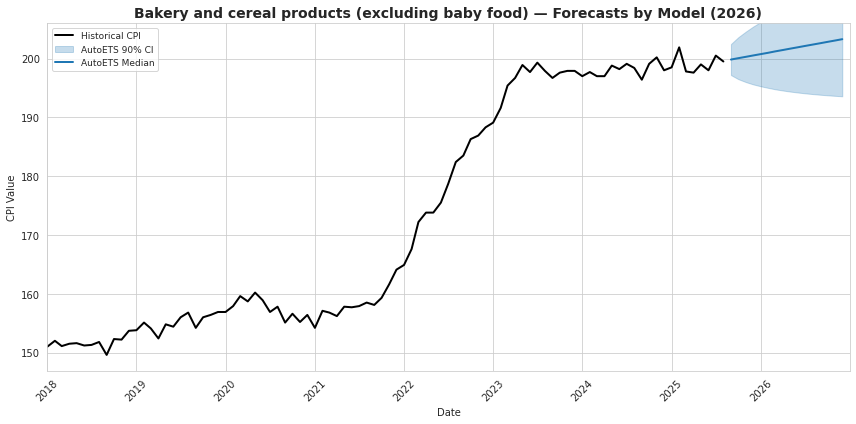


📈 Plotting category: Dairy products and eggs
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Dairy products and eggs_Forecasts.png


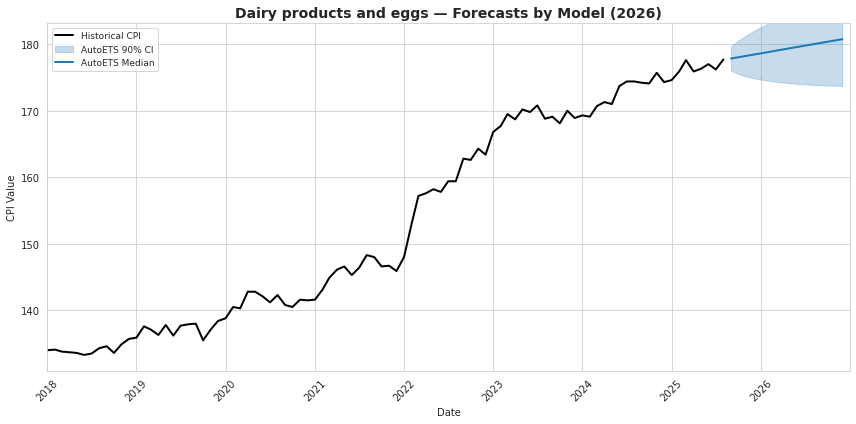


📈 Plotting category: Fish, seafood and other marine products
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Fish, seafood and other marine products_Forecasts.png


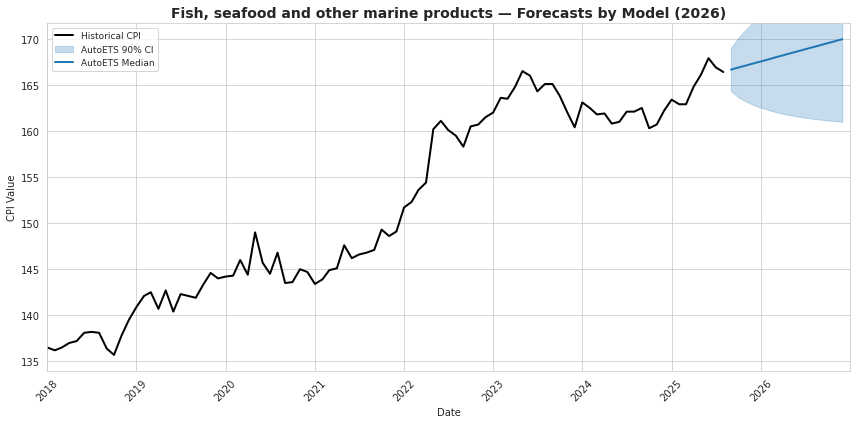


📈 Plotting category: Food purchased from restaurants
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Food purchased from restaurants_Forecasts.png


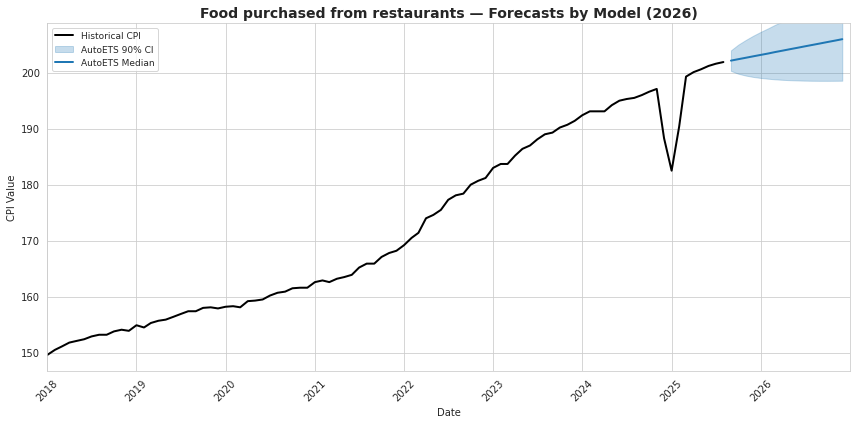


📈 Plotting category: Food
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Food_Forecasts.png


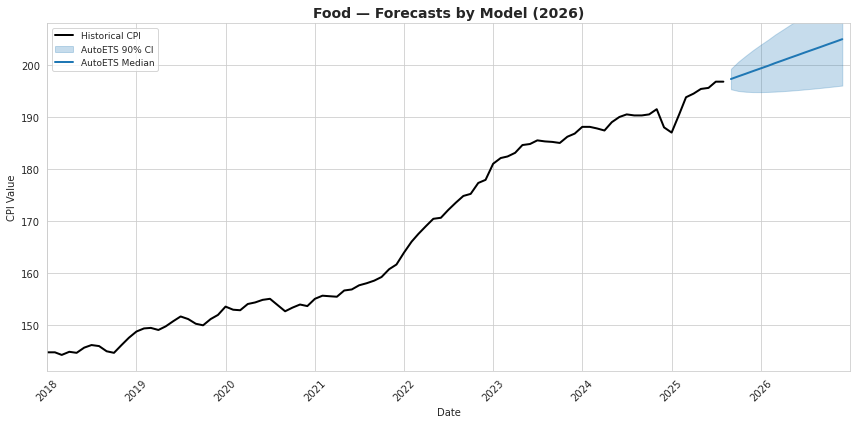


📈 Plotting category: Fruit, fruit preparations and nuts
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Fruit, fruit preparations and nuts_Forecasts.png


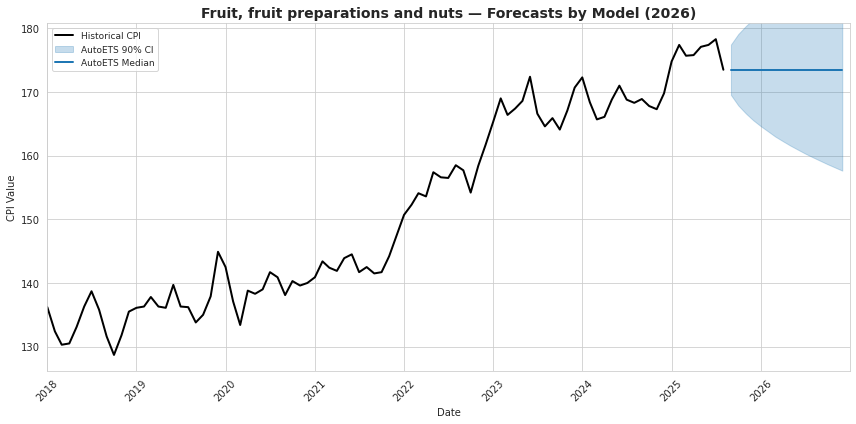


📈 Plotting category: Meat
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Meat_Forecasts.png


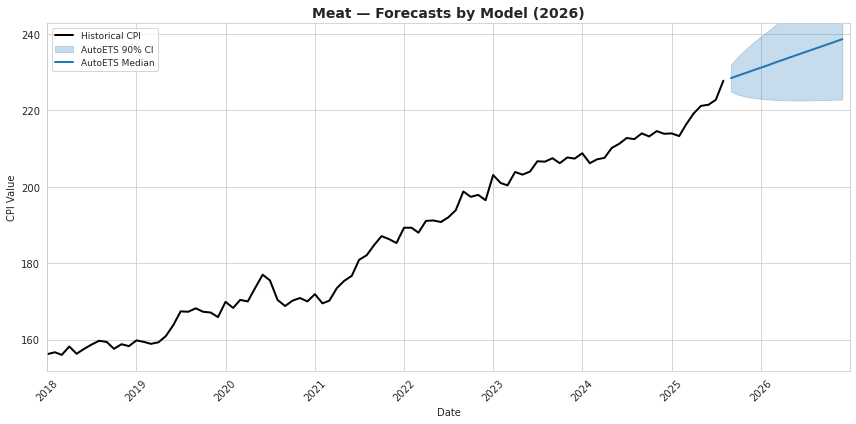


📈 Plotting category: Other food products and non-alcoholic beverages
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Other food products and non-alcoholic beverages_Forecasts.png


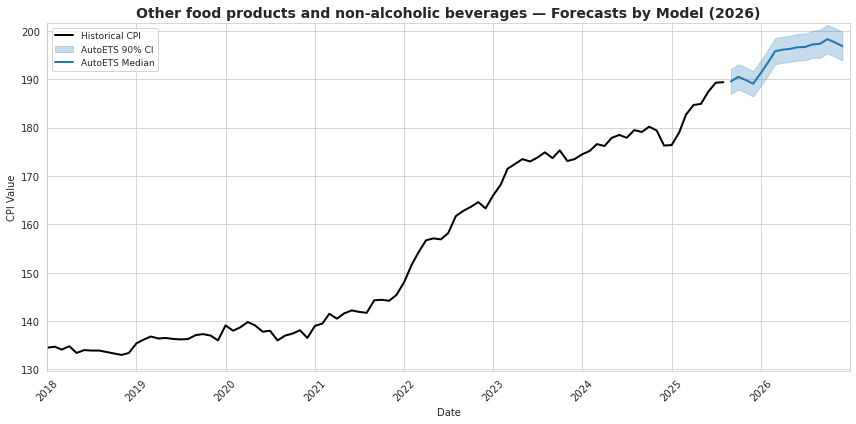


📈 Plotting category: Vegetables and vegetable preparations
💾 Saved → /h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts/plots_exact/Vegetables and vegetable preparations_Forecasts.png


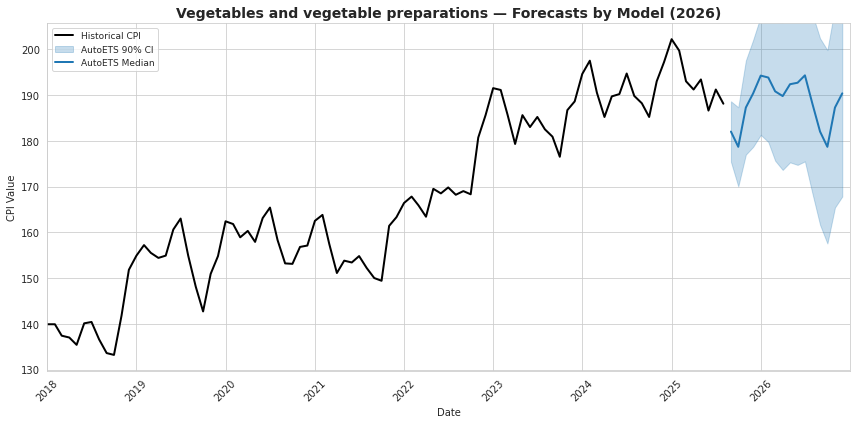


✅ Done plotting all categories (exact match only).


In [5]:
# ======================================================================
# 📊 VISUALIZE FINAL 2026 FORECASTS (Exact category match only)
# ======================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


def plot_all_final_forecasts_exact(
    ts_df,
    food_categories,
    model_list,
    base_dir,
    show_plots=True,
    save_plots=True,
    start_year=2018,
    forecast_year="2026"
):
    """
    Plot all final forecasts for all categories and models with confidence bands.
    STRICT version: exact category match only (no prefix, no fuzzy search).

    Parameters
    ----------
    ts_df : pd.DataFrame
        MultiIndex TimeSeriesDataFrame (item_id, timestamp).
    food_categories : list
        Exact category names to visualize (must match ts_df item_id exactly).
    model_list : list
        List of model names to include.
    base_dir : str
        Directory containing saved forecast CSVs (category/model organized).
    """
    sns.set_style("whitegrid")

    plot_dir = os.path.join(base_dir, "plots_exact")
    os.makedirs(plot_dir, exist_ok=True)

    for category in food_categories:
        print(f"\n📈 Plotting category: {category}")

        # ------------------------------------------------------------------
        # Load the ground truth
        # ------------------------------------------------------------------
        if category not in ts_df.index.get_level_values("item_id"):
            print(f"❌ '{category}' not found in ts_df item_id index — skipping.")
            continue

        series = ts_df.loc[category]
        if isinstance(series, pd.DataFrame) and "target" in series.columns:
            series = series["target"]
        series.index = pd.to_datetime(series.index)
        series = series.sort_index()

        context_df = series[series.index <= "2025-08-01"]
        actual_df = series[series.index > "2025-08-01"]

        # Restrict to recent years only
        context_df = context_df[context_df.index >= pd.Timestamp(f"{start_year}-01-01")]

        # ------------------------------------------------------------------
        # Load forecasts
        # ------------------------------------------------------------------
        category_clean = category.replace("/", "_")
        forecast_dir = os.path.join(base_dir, category_clean, forecast_year)

        forecast_dict = {}
        for model_name in model_list:
            forecast_path = os.path.join(forecast_dir, f"{category}_{model_name}_forecasts.csv")
            if not os.path.exists(forecast_path):
                print(f"⚠️ Missing forecast for {category} ({model_name}) → {forecast_path}")
                continue

            forecast_df = pd.read_csv(forecast_path)
            forecast_df["timestamp"] = pd.to_datetime(forecast_df["timestamp"], errors="coerce")
            forecast_df = forecast_df.dropna(subset=["timestamp"]).set_index("timestamp").sort_index()
            forecast_dict[model_name] = forecast_df

        if not forecast_dict:
            print(f"⚠️ No forecast files found for {category}, skipping.")
            continue

        # ------------------------------------------------------------------
        # Plot
        # ------------------------------------------------------------------
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(context_df.index, context_df.values, color="black", linewidth=2, label="Historical CPI")

        if len(actual_df) > 0:
            ax.plot(actual_df.index, actual_df.values, color="gray", linewidth=2, linestyle="--", label="Observed (Actual)")

        palette = sns.color_palette("tab10", n_colors=len(forecast_dict))

        for i, (model_name, fdf) in enumerate(forecast_dict.items()):
            # Ensure q_0.5 exists
            if "q_0.5" not in fdf.columns:
                if "mean" in fdf.columns:
                    fdf["q_0.5"] = fdf["mean"]
                else:
                    print(f"⚠️ Skipping {model_name}: no median/mean column.")
                    continue

            # Confidence band
            if {"q_0.05", "q_0.95"}.issubset(fdf.columns):
                ax.fill_between(
                    fdf.index,
                    fdf["q_0.05"],
                    fdf["q_0.95"],
                    color=palette[i],
                    alpha=0.25,
                    label=f"{model_name} 90% CI",
                )

            # Median line
            ax.plot(
                fdf.index,
                fdf["q_0.5"],
                color=palette[i],
                linewidth=2,
                label=f"{model_name} Median",
            )

        ax.set_title(f"{category} — Forecasts by Model ({forecast_year})", fontsize=14, fontweight="bold")
        ax.set_xlabel("Date")
        ax.set_ylabel("CPI Value")
        ax.legend(loc="upper left", fontsize=9)
        ax.set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp("2026-12-31"))
        plt.xticks(rotation=45)
        
        # --------------------------------------------------------------
        # ✅ Adjust Y-axis limits (ignore extreme CI outliers)
        # --------------------------------------------------------------
        y_min = min(context_df.min(), *(fdf["q_0.5"].min() for fdf in forecast_dict.values() if "q_0.5" in fdf))
        y_max = max(context_df.max(), *(fdf["q_0.5"].max() for fdf in forecast_dict.values() if "q_0.5" in fdf))

        # Add small margin (e.g. 5% buffer)
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)

        
        plt.tight_layout()

        # Save or show
        save_path = os.path.join(plot_dir, f"{category_clean}_Forecasts.png")
        if save_plots:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"💾 Saved → {save_path}")
        if show_plots:
            plt.show()
        else:
            plt.close()

    print("\n✅ Done plotting all categories (exact match only).")
    
final_output_dir = "/h/kupfersk/cfpr_2026/generate_forecasts/output/Final_2026_Forecasts"

plot_all_final_forecasts_exact(
    ts_df=ts_df,
    food_categories=food_categories,
    model_list=model_list,
    base_dir=final_output_dir,
    show_plots=True,
    save_plots=True,
    start_year=2018
)

